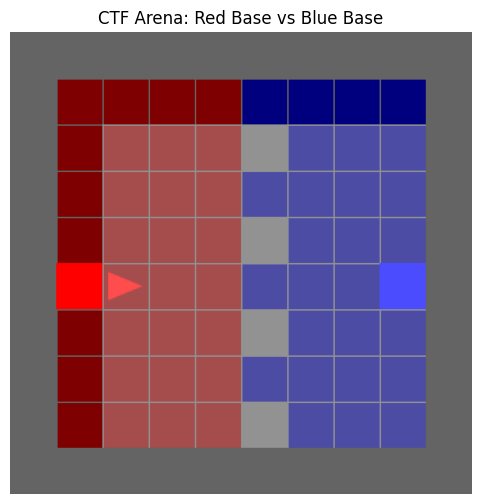

In [1]:
import matplotlib.pyplot as plt
from ctf_env import CaptureTheFlagEnv

# Initialize
env = CaptureTheFlagEnv(size=10, render_mode="rgb_array")
env.reset()

# Show the full map
plt.figure(figsize=(6,6))
plt.imshow(env.render())
plt.title("CTF Arena: Red Base vs Blue Base")
plt.axis('off')
plt.show()

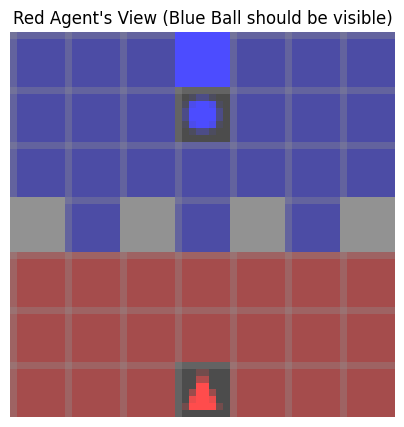

In [2]:
import matplotlib.pyplot as plt
from ctf_env import CaptureTheFlagEnv

# 1. Initialize with render_mode="rgb_array"
# You DO NOT need RGBImgObsWrapper anymore
env = CaptureTheFlagEnv(size=10, render_mode="rgb_array")
env.reset()

# 2. Get Observation (Now returns RGB automatically)
obs_red = env.get_obs_for_agent(1)

# 3. Visualize
plt.figure(figsize=(5,5))
plt.imshow(obs_red['image'])
plt.title("Red Agent's View (Blue Ball should be visible)")
plt.axis('off')
plt.show()

In [3]:
import minigrid
import gymnasium
import torch
import stable_baselines3
from ctf_env import CaptureTheFlagEnv

print("Everything is installed correctly!")

Everything is installed correctly!
